In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# from hurst import compute_Hc

In [2]:
!pip install hurst

In [3]:
 from hurst import compute_Hc

In [20]:
# prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')
# prices = prices.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'Timestamp' else col)
# prices
# for column in prices.columns[1:]:
#     # Convert all values in the column to their absolute values
#     prices[column] = prices[prices].abs()
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)



In [21]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)


In [22]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]

    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint

    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]

    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]

    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread) < 2*hist_sd).sum() / len(spread) * 100

    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

In [23]:
def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'Num zero-crossings', 'Pearson r',
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = cadf_pvalue(s1,s2,train)
                if cadf_p<0.01:
                    spread = train[s1] - train[s2]
                    hurst = compute_Hc(spread)[0]
                    if hurst<0.5:
                        halflife = calculate_halflife(spread)
                        if halflife>1 and halflife<30:
                            num_crossings = (spread.values[1:] * spread.values[:-1] < 0).sum()
                            if num_crossings>len(train.index)/252*12:
                                distance = np.sqrt(np.sum((train[s1] - train[s2])**2)) # Euclidean distance
                                pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                spread_sd = spread.std()
                                pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r,
                                                           spread_sd, hurst, halflife]

    return pairs


In [24]:
cumret12_6 = cumret.loc['2016-06-15':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2016-06-20':'2020-06-30'] # formation period
test12_6 = cumret12_6.loc['2020-08-01':'2021-10-30'] # trading period
test12_6

,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2020-08-03,1.385389,1.423453,1.439446,1.452960,1.479334,1.494573,1.503102,1.514062,1.520985,1.531491,1.546058,1.563366,1.583173,1.597800,1.614784,1.629888,1.644830,1.667499,1.693967,1.729704
2020-08-04,1.365324,1.400113,1.413580,1.426223,1.452212,1.467333,1.476021,1.487173,1.494401,1.506173,1.521028,1.538679,1.559906,1.575065,1.592658,1.608383,1.623905,1.646936,1.672524,1.708541
2020-08-05,1.311076,1.343820,1.354903,1.364674,1.388679,1.404188,1.413010,1.425332,1.435021,1.448315,1.463610,1.482884,1.505845,1.521965,1.540688,1.557554,1.574100,1.597610,1.623671,1.660035
2020-08-06,1.317028,1.352425,1.366317,1.378174,1.404566,1.419738,1.427110,1.436917,1.444898,1.457422,1.471931,1.490356,1.512421,1.528691,1.546411,1.563404,1.578904,1.601357,1.627575,1.664126
2020-08-07,1.367486,1.405412,1.423818,1.439239,1.468367,1.484956,1.494122,1.506686,1.516268,1.530524,1.548045,1.568466,1.591558,1.609592,1.629019,1.648910,1.666653,1.692581,1.722586,1.763596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,1.070069,1.108756,1.102685,1.093575,1.099415,1.099715,1.095790,1.092398,1.089394,1.084042,1.082361,1.078621,1.075386,1.066253,1.060711,1.061743,1.065850,1.080311,1.090592,1.105319
2021-10-26,1.105110,1.151566,1.143081,1.130978,1.135792,1.134462,1.128396,1.122695,1.117029,1.110173,1.106888,1.104093,1.100488,1.090834,1.083159,1.081799,1.083368,1.093580,1.101007,1.114456
2021-10-27,0.943477,0.986952,0.971196,0.954616,0.954788,0.953247,0.946470,0.940078,0.936199,0.930705,0.927404,0.926271,0.922836,0.912655,0.904915,0.901053,0.901658,0.912985,0.919224,0.924743


In [25]:
pairs12_6 = select_pairs(train12_6)
pairs12_6

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr1-Instr2,17.839007,87.0,0.954889,0.552283,0.408068,1.218231
Instr1-Instr3,21.606681,87.0,0.933930,0.667950,0.338112,1.134417
Instr1-Instr4,24.992272,87.0,0.911932,0.771284,0.366050,1.159664
Instr1-Instr5,25.531026,85.0,0.907278,0.784175,0.349499,1.395285
Instr1-Instr6,29.812928,71.0,0.875774,0.915708,0.372485,1.310675
Instr1-Instr8,30.596241,57.0,0.867185,0.928096,0.333087,1.506506
Instr1-Instr13,36.873011,51.0,0.807703,1.096677,0.320427,1.752736
Instr1-Instr15,40.493782,55.0,0.768724,1.209643,0.332087,2.017296
Instr2-Instr3,12.887225,61.0,0.976337,0.399058,0.375005,1.006896
Instr2-Instr4,18.322086,57.0,0.952343,0.566409,0.394367,1.121164


In [26]:
pairs12_6.sort_values(by='Euclidean distance')

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr2-Instr3,12.887225,61.0,0.976337,0.399058,0.375005,1.006896
Instr3-Instr5,14.627678,59.0,0.969437,0.450056,0.313402,1.065391
Instr1-Instr2,17.839007,87.0,0.954889,0.552283,0.408068,1.218231
Instr2-Instr4,18.322086,57.0,0.952343,0.566409,0.394367,1.121164
Instr6-Instr10,19.265949,55.0,0.949660,0.581266,0.329405,1.015887
Instr2-Instr5,19.857669,67.0,0.943603,0.610854,0.366502,1.471018
Instr3-Instr6,20.910633,59.0,0.938247,0.644106,0.340083,1.084725
Instr1-Instr3,21.606681,87.0,0.933930,0.667950,0.338112,1.134417
Instr3-Instr7,21.723088,53.0,0.932748,0.664519,0.313900,1.119745
Instr1-Instr4,24.992272,87.0,0.911932,0.771284,0.366050,1.159664


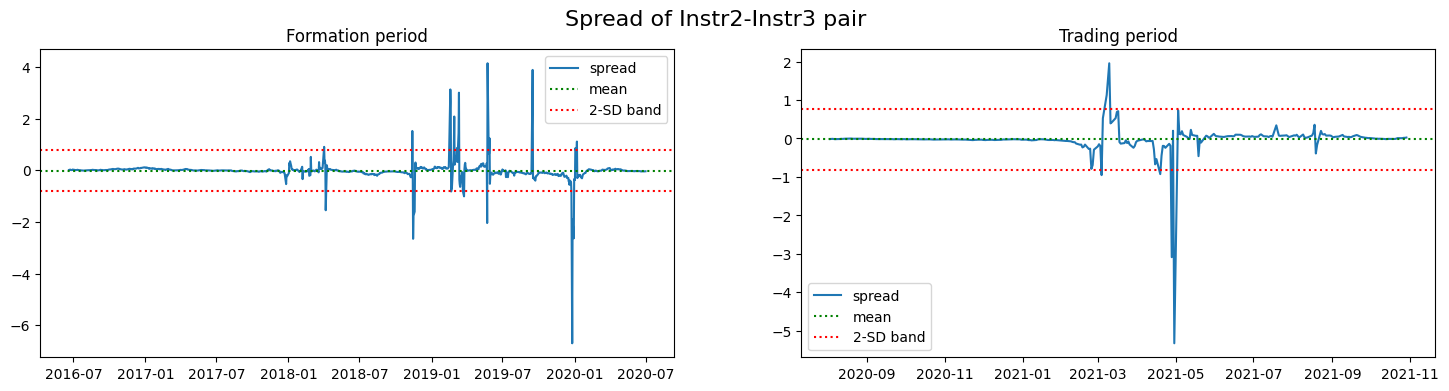

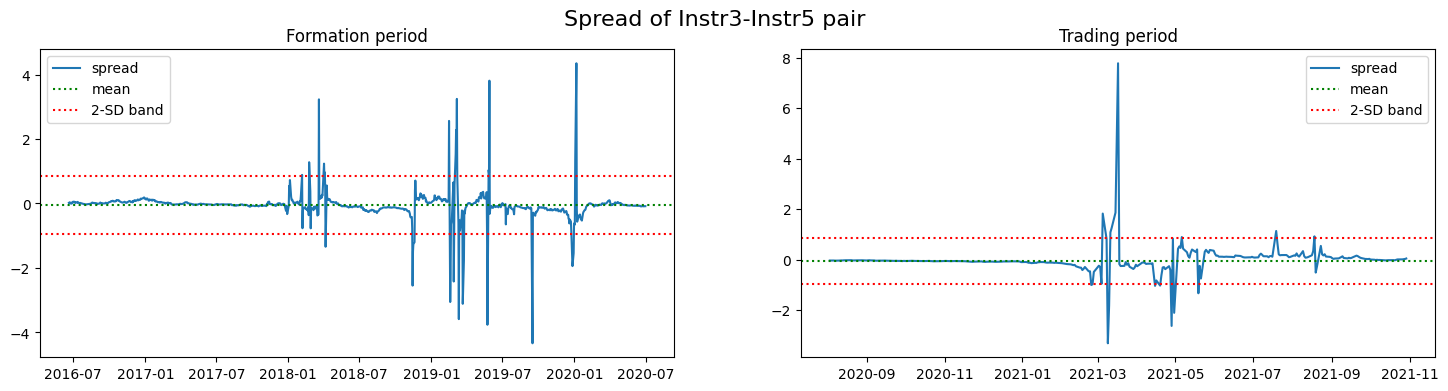

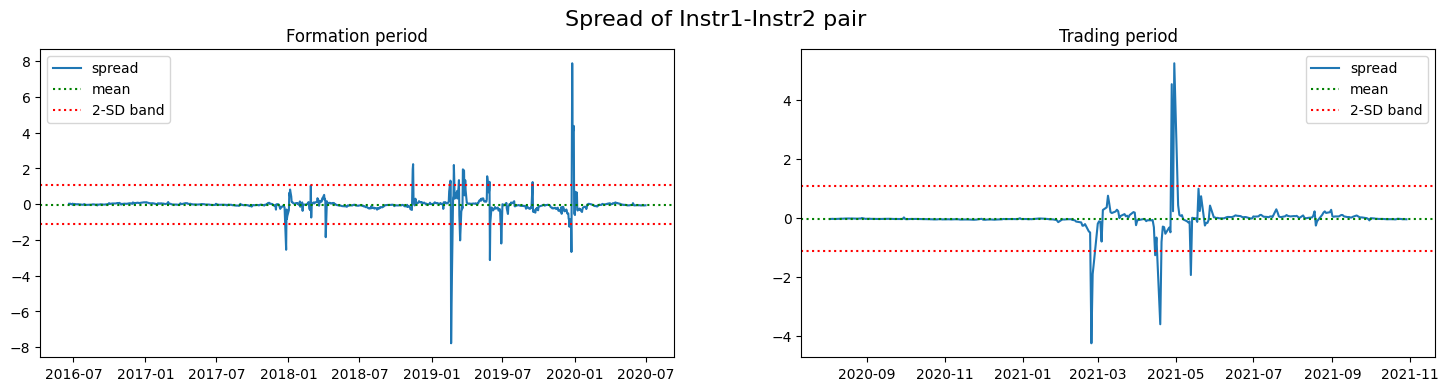

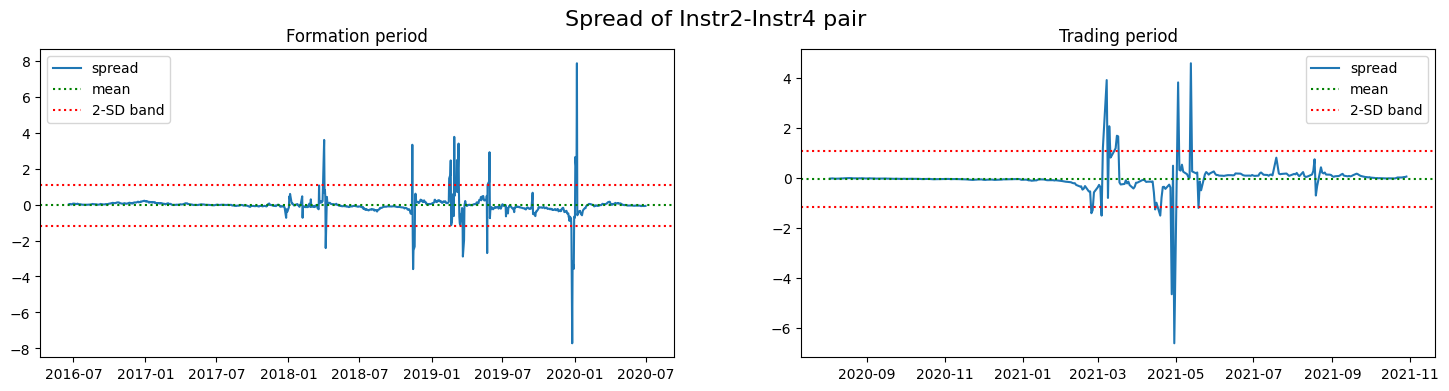

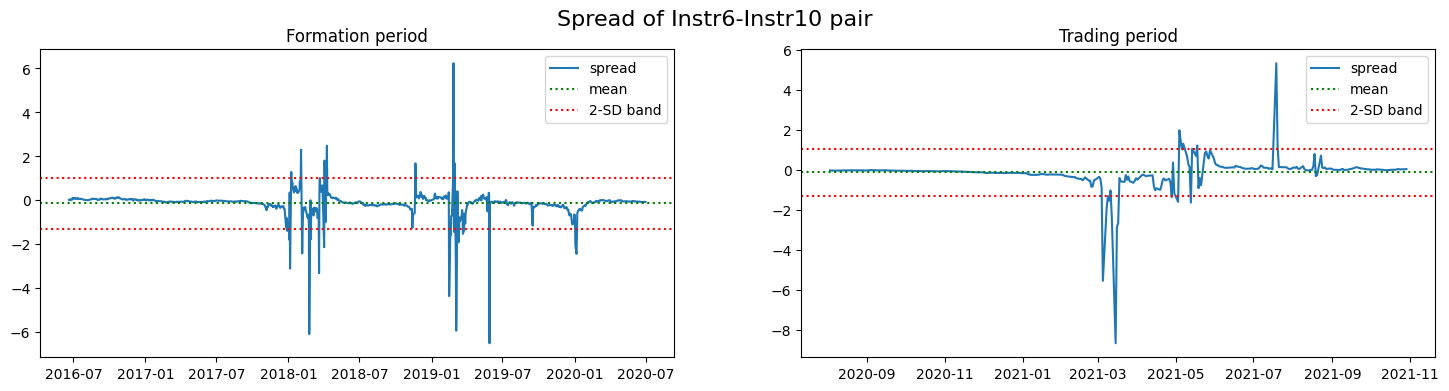

In [27]:
top5_distance = list(pairs12_6.sort_values(by='Euclidean distance').index[:5])
plot_pairs(top5_distance, train12_6, test12_6)


In [28]:
pairs12_6.sort_values(by='Num zero-crossings', ascending=False)


,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr1-Instr2,17.839007,87.0,0.954889,0.552283,0.408068,1.218231
Instr1-Instr4,24.992272,87.0,0.911932,0.771284,0.366050,1.159664
Instr1-Instr3,21.606681,87.0,0.933930,0.667950,0.338112,1.134417
Instr1-Instr5,25.531026,85.0,0.907278,0.784175,0.349499,1.395285
Instr1-Instr6,29.812928,71.0,0.875774,0.915708,0.372485,1.310675
Instr2-Instr5,19.857669,67.0,0.943603,0.610854,0.366502,1.471018
Instr2-Instr3,12.887225,61.0,0.976337,0.399058,0.375005,1.006896
Instr3-Instr6,20.910633,59.0,0.938247,0.644106,0.340083,1.084725
Instr3-Instr5,14.627678,59.0,0.969437,0.450056,0.313402,1.065391
Instr12-Instr20,30.836734,57.0,0.879529,0.956179,0.350533,1.111733


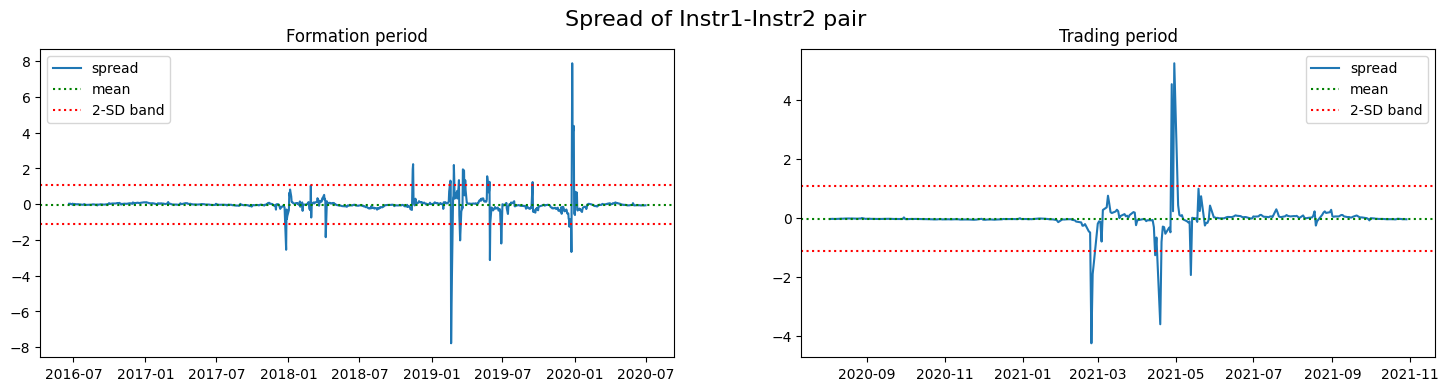

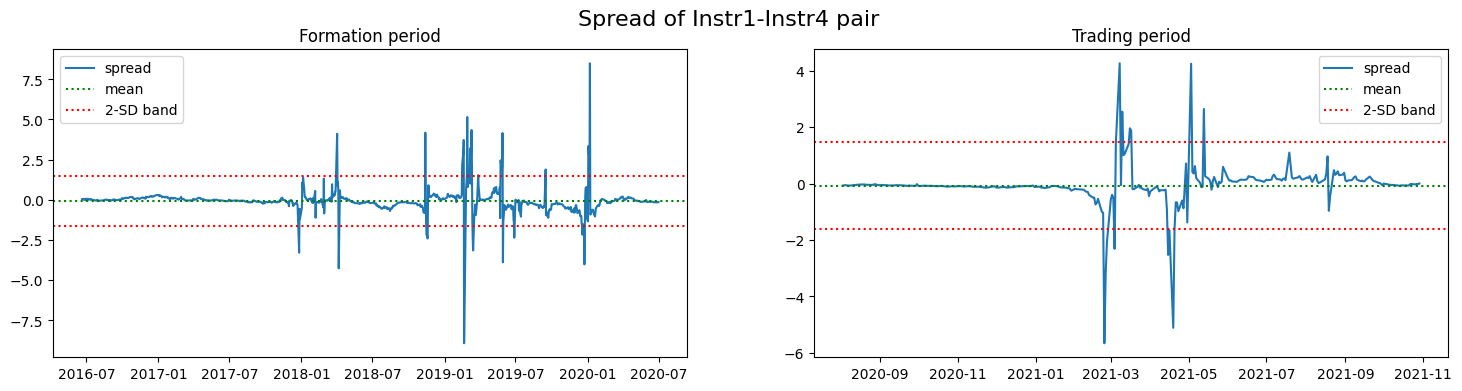

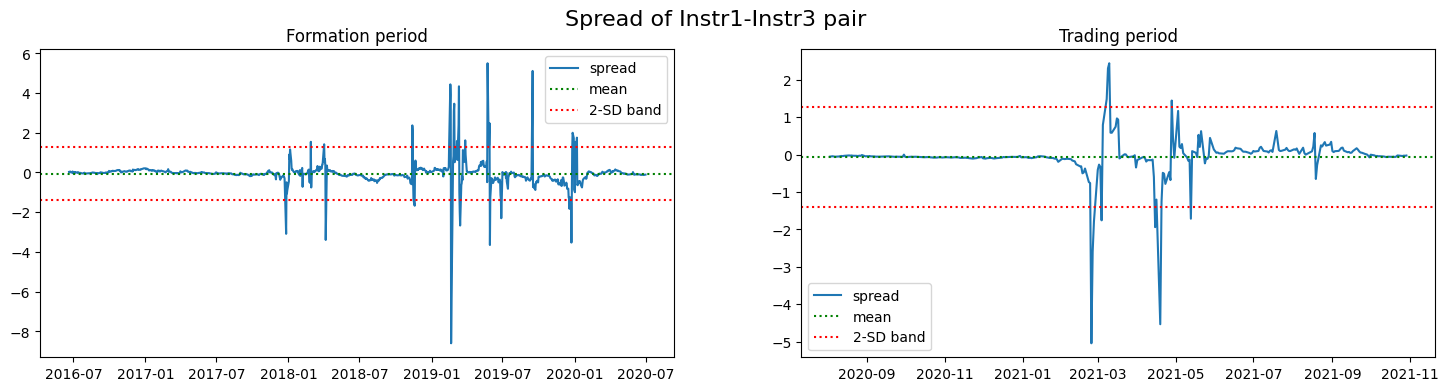

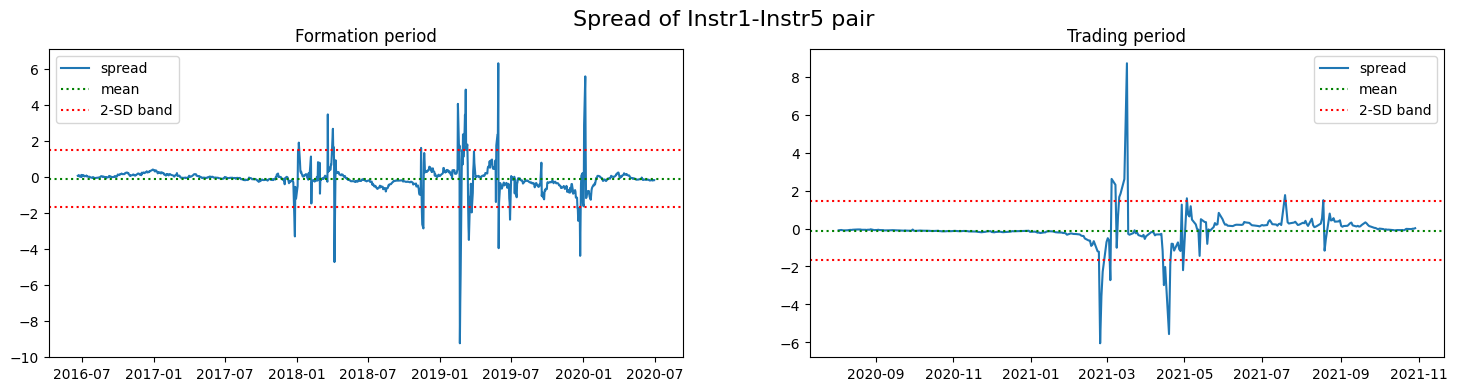

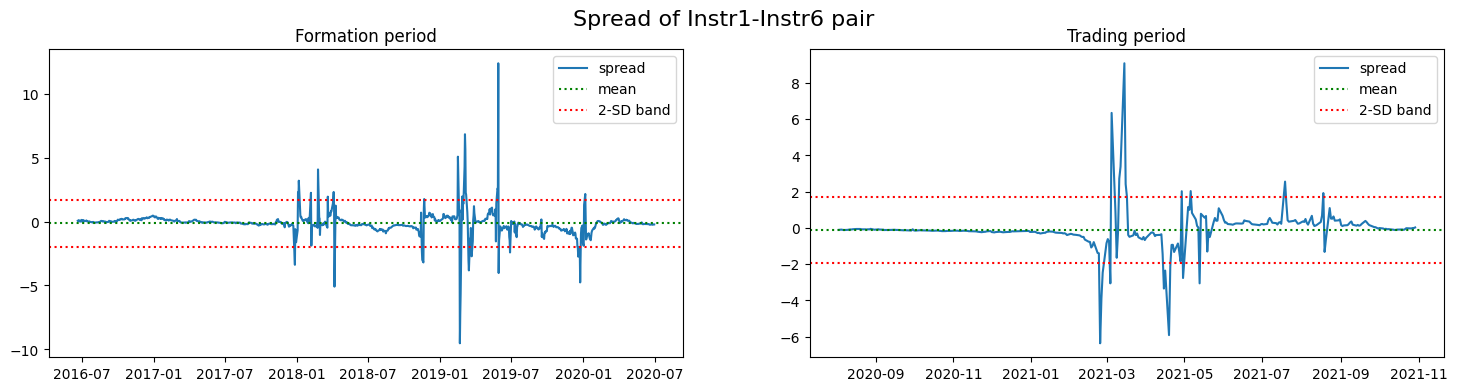

In [29]:
top5_crossings = list(pairs12_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train12_6, test12_6)

In [30]:
calculate_metrics(top5_crossings, test12_6, pairs12_6)


,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr1-Instr2,9.91908,0.000298,0.000011,0.552283,0.962969,26,0.44488,0.936453,97.515528
Instr1-Instr4,13.234229,0.000067,0.000003,0.771284,0.934159,17,0.400445,1.255435,95.652174
Instr1-Instr3,9.958062,0.0,0.0,0.66795,0.96196,18,0.443766,1.593876,96.583851
Instr1-Instr5,17.137846,0.013808,0.000956,0.784175,0.891163,15,0.450994,1.494317,94.409938
Instr1-Instr6,19.196065,0.045406,0.004387,0.915708,0.8626,15,0.393611,1.271372,93.78882


In [31]:
pairs12_6.sort_values(by='Pearson r', ascending=False)


,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr2-Instr3,12.887225,61.0,0.976337,0.399058,0.375005,1.006896
Instr3-Instr5,14.627678,59.0,0.969437,0.450056,0.313402,1.065391
Instr1-Instr2,17.839007,87.0,0.954889,0.552283,0.408068,1.218231
Instr2-Instr4,18.322086,57.0,0.952343,0.566409,0.394367,1.121164
Instr6-Instr10,19.265949,55.0,0.949660,0.581266,0.329405,1.015887
Instr2-Instr5,19.857669,67.0,0.943603,0.610854,0.366502,1.471018
Instr3-Instr6,20.910633,59.0,0.938247,0.644106,0.340083,1.084725
Instr1-Instr3,21.606681,87.0,0.933930,0.667950,0.338112,1.134417
Instr3-Instr7,21.723088,53.0,0.932748,0.664519,0.313900,1.119745
Instr1-Instr4,24.992272,87.0,0.911932,0.771284,0.366050,1.159664


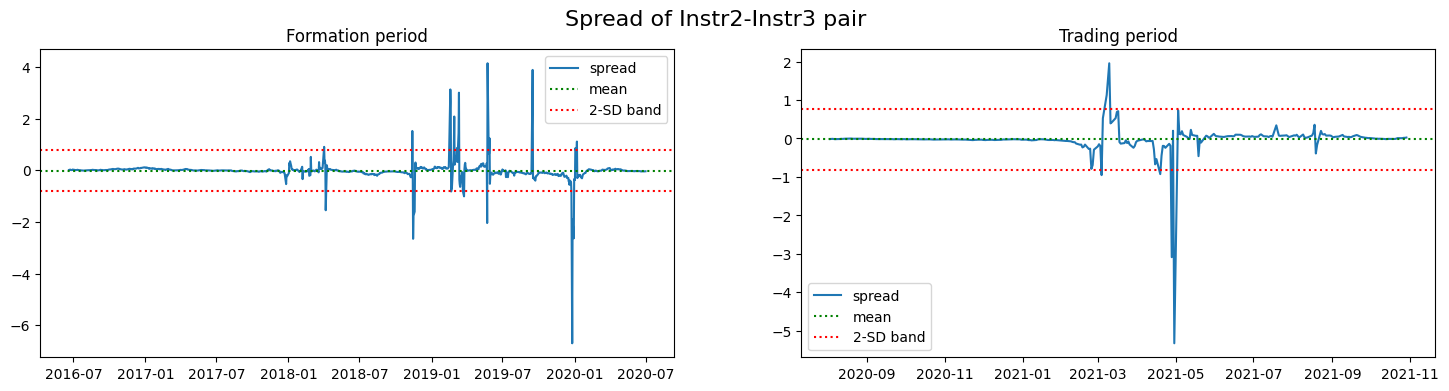

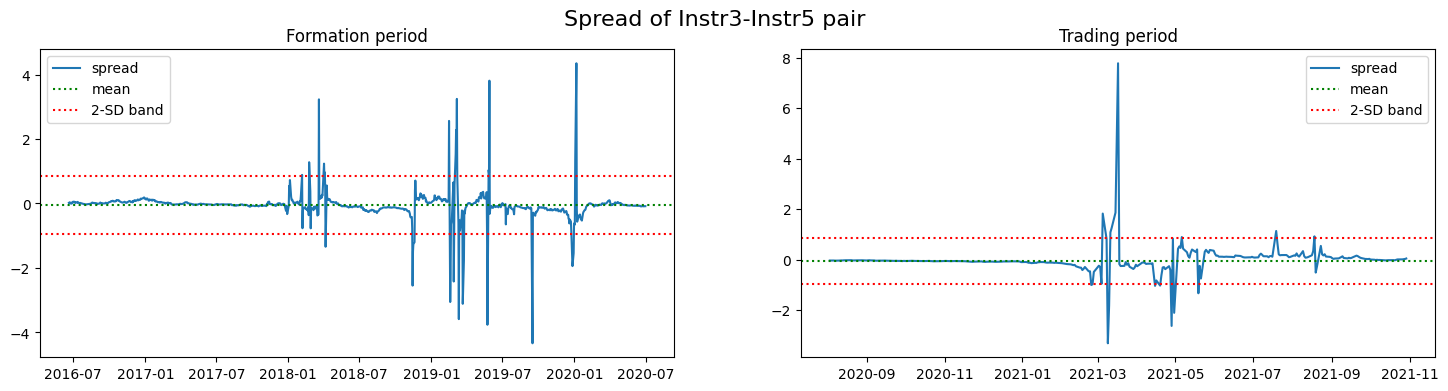

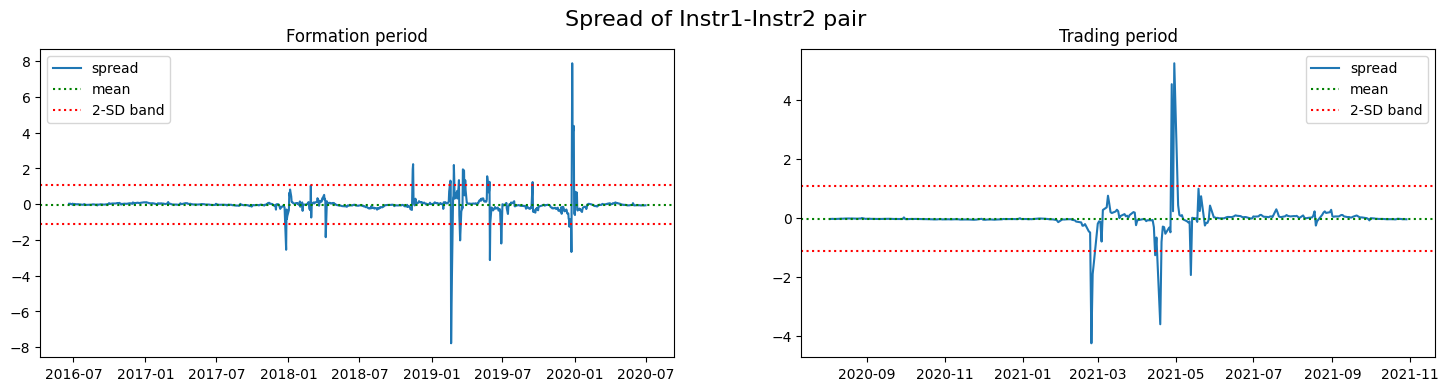

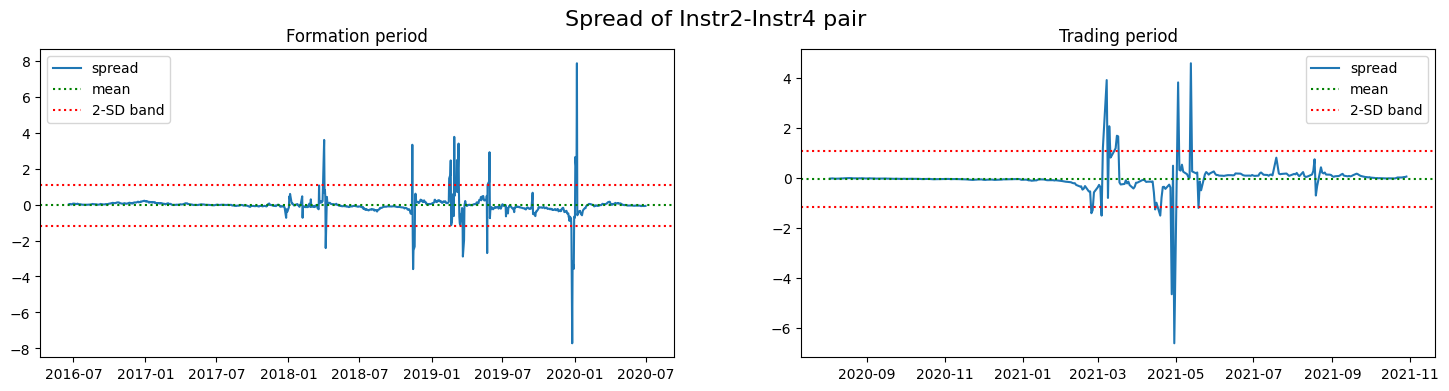

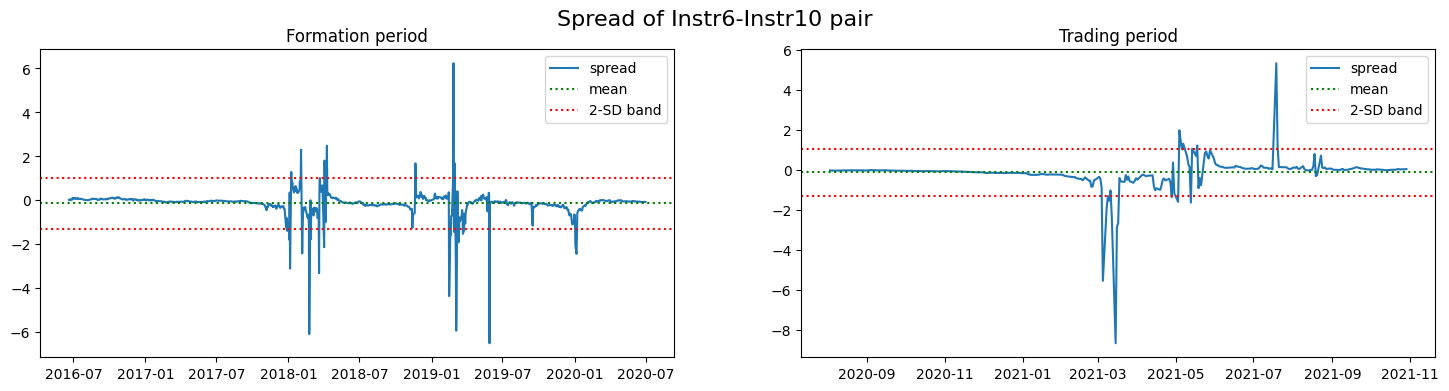

In [32]:
top5_pearson = list(pairs12_6.sort_values(by='Pearson r', ascending=False).index[:5])
plot_pairs(top5_pearson, train12_6, test12_6)

In [33]:
calculate_metrics(top5_pearson, test12_6, pairs12_6)


,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr2-Instr3,7.353046,0.000068,0.00001,0.399058,0.979823,13,0.369644,0.776569,97.826087
Instr3-Instr5,11.815422,0.000124,0.000018,0.450056,0.947659,13,0.409262,1.188314,94.409938
Instr1-Instr2,9.91908,0.000298,0.000011,0.552283,0.962969,26,0.44488,0.936453,97.515528
Instr2-Instr4,12.398662,0.000011,0.000001,0.566409,0.942354,13,0.305336,0.667357,95.031056
Instr6-Instr10,14.507469,0.018441,0.003679,0.581266,0.921979,23,0.421666,1.372063,94.409938


In [35]:
cumret36_6 = cumret.loc['2020-03-15':]
cumret36_6 = cumret36_6 / cumret36_6.iloc[0] # divide by first row so that all prices start at 1
train36_6 = cumret36_6.loc['2020-07-01':'2021-06-30'] # formation period
test36_6 = cumret36_6.loc['2021-07-01':'2022-12-30'] # trading period
pairs36_6 = select_pairs(train36_6)
pairs36_6

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr1-Instr3,4.535174,13.0,0.962542,0.279039,0.420910,1.576648
Instr1-Instr4,6.012011,13.0,0.934827,0.371720,0.426942,1.237798


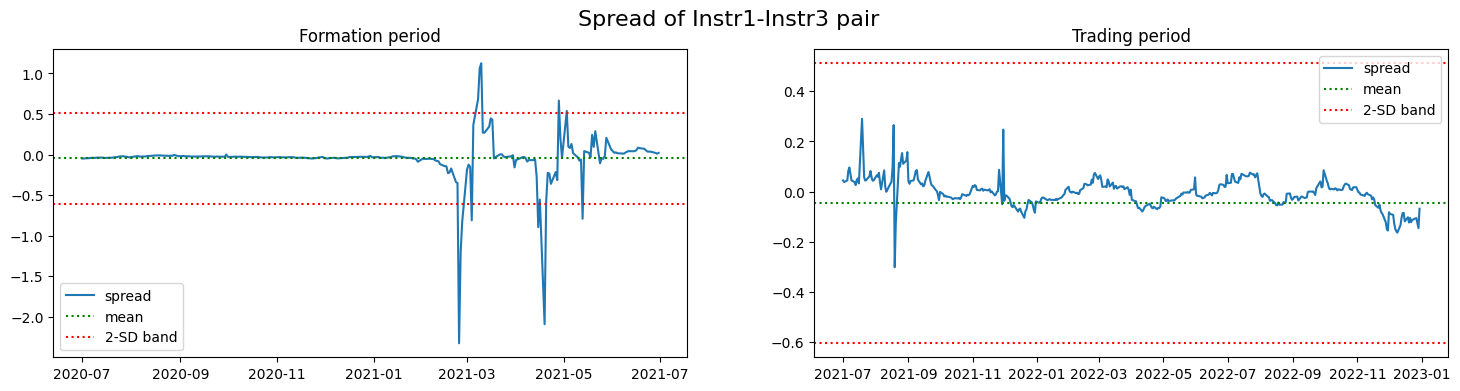

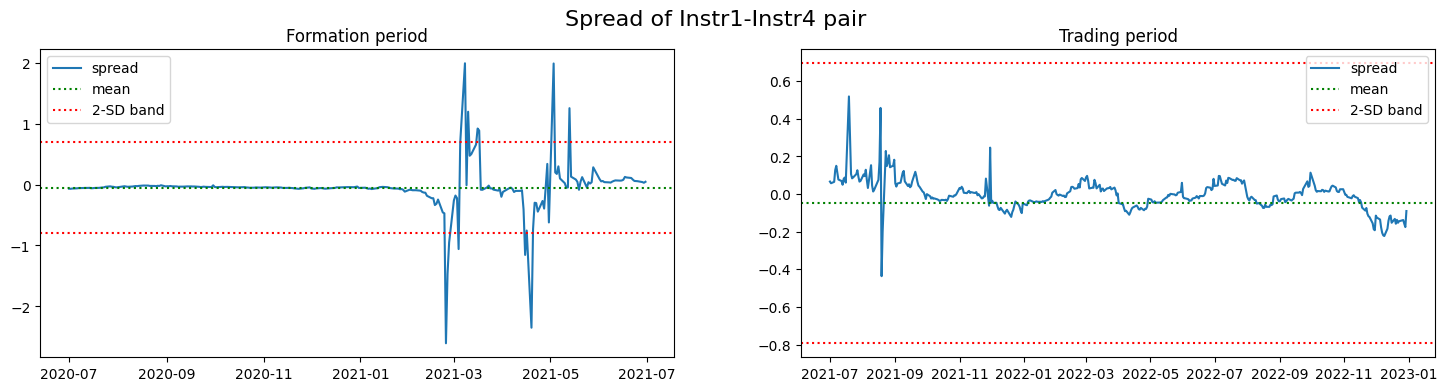

In [36]:
top5_distance = list(pairs36_6.sort_values(by='Euclidean distance').index[:5])
plot_pairs(top5_distance, train36_6, test36_6)

In [37]:
calculate_metrics(top5_distance, test36_6, pairs36_6)


,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr1-Instr3,1.178721,0.214596,0.087165,0.279039,0.995512,27,0.318719,2.244373,100.0
Instr1-Instr4,1.66436,0.21834,0.087714,0.37172,0.991447,25,0.334317,2.086376,100.0


In [38]:
pairs36_6.sort_values(by='Num zero-crossings', ascending=False)


,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr1-Instr3,4.535174,13.0,0.962542,0.279039,0.420910,1.576648
Instr1-Instr4,6.012011,13.0,0.934827,0.371720,0.426942,1.237798


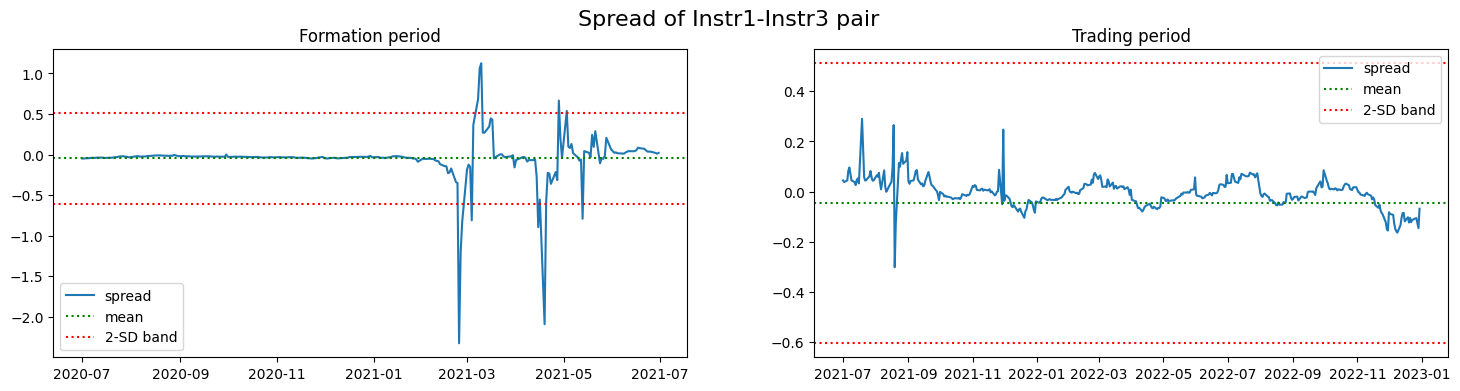

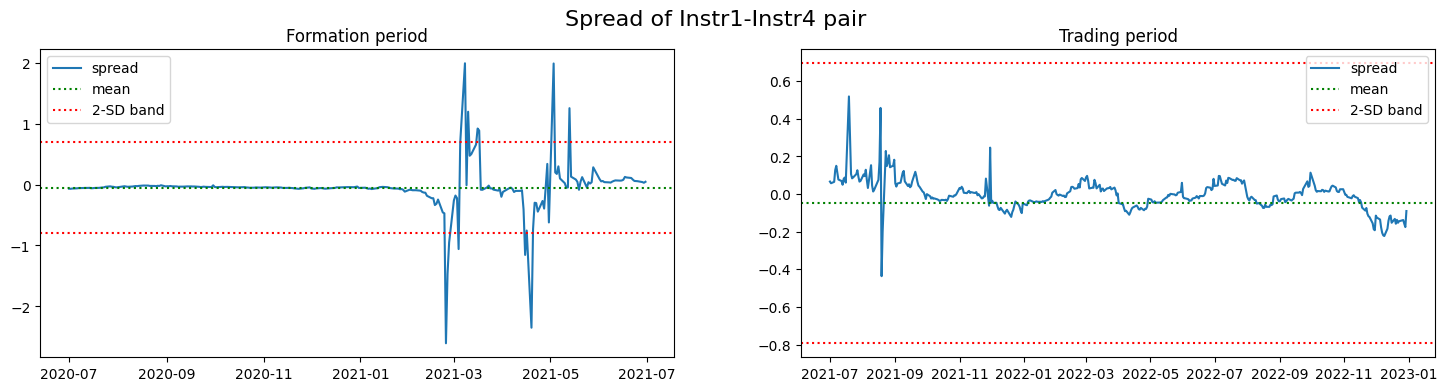

In [39]:
top5_crossings = list(pairs36_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train36_6, test36_6)